### Problem statement

#### Melanoma, a deadly skin cancer, is curable if detected early. This project aims to develop a CNN-based model to accurately detect melanoma from dermatological images, potentially assisting dermatologists and reducing manual diagnosis efforts.

The dataset comprises 2357 images of various malignant and benign skin conditions from the International Skin Imaging Collaboration (ISIC). It includes a diverse set of diseases, with a slight dominance of melanoma and mole images.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Importing Skin Cancer Data

#### Paths are defined for the training and test images. The dataset is sorted according to ISIC classifications, with nine classes represented.


In [45]:
import os
import pathlib

# This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

# Assuming this script is in same folder as extracted 'CNN_assignment' folder
# Defining the path for train and test images
data_dir_train = pathlib.Path("CNN_assignment", "Skin cancer ISIC The International Skin Imaging Collaboration", "Train")
#print(data_dir_train.resolve())

data_dir_test = pathlib.Path("CNN_assignment", "Skin cancer ISIC The International Skin Imaging Collaboration", "Test")
#print(data_dir_test.resolve())


### Data Understanding

In [46]:
%%time

# Display images count in both Train and Test folders.

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118
CPU times: total: 31.2 ms
Wall time: 35.8 ms


In [6]:
%%time

# Display classes with significant imbalance

import pathlib
import tensorflow as tf

# Load the datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    image_size=(180, 180),
    batch_size=32
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    image_size=(180, 180),
    batch_size=32
)

# Function to count instances for each class in the dataset
def count_instances(ds, class_names):
    class_counts = dict.fromkeys(class_names, 0)
    for images, labels in ds.unbatch().as_numpy_iterator():
        class_name = class_names[labels]  # Use class_names directly passed to the function
        class_counts[class_name] += 1
    return class_counts

# Retrieve class names from the datasets
train_class_names = train_ds.class_names
test_class_names = test_ds.class_names

# Count instances in training and test datasets
train_counts = count_instances(train_ds, train_class_names)
test_counts = count_instances(test_ds, test_class_names)

# Display counts
print("Training dataset counts:")
for class_name, count in train_counts.items():
    print(f"{class_name}: {count}")

print("\nTest dataset counts:")
for class_name, count in test_counts.items():
    print(f"{class_name}: {count}")

# Identifying imbalances (example approach)
imbalance_threshold = 0.2  # 20% difference as an example threshold
max_train = max(train_counts.values())
max_test = max(test_counts.values())

print("\nClasses of imbalance in training dataset:")
for class_name, count in train_counts.items():
    if count < (1 - imbalance_threshold) * max_train or count > (1 + imbalance_threshold) * max_train:
        print(f"{class_name}: {count}")

print("\nClasses of imbalance in test dataset:")
for class_name, count in test_counts.items():
    if count < (1 - imbalance_threshold) * max_test or count > (1 + imbalance_threshold) * max_test:
        print(f"{class_name}: {count}")


Found 2239 files belonging to 9 classes.
Found 118 files belonging to 9 classes.
Training dataset counts:
actinic keratosis: 114
basal cell carcinoma: 376
dermatofibroma: 95
melanoma: 438
nevus: 357
pigmented benign keratosis: 462
seborrheic keratosis: 77
squamous cell carcinoma: 181
vascular lesion: 139

Test dataset counts:
actinic keratosis: 16
basal cell carcinoma: 16
dermatofibroma: 16
melanoma: 16
nevus: 16
pigmented benign keratosis: 16
seborrheic keratosis: 3
squamous cell carcinoma: 16
vascular lesion: 3

Classes of imbalance in training dataset:
actinic keratosis: 114
dermatofibroma: 95
nevus: 357
seborrheic keratosis: 77
squamous cell carcinoma: 181
vascular lesion: 139

Classes of imbalance in test dataset:
seborrheic keratosis: 3
vascular lesion: 3
CPU times: total: 22.6 s
Wall time: 13.8 s


In [48]:
from pathlib import Path
import numpy as np

# data_dir_train is the training dataset path
data_dir_train = Path("CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")

# Count the number of files in each class directory
class_counts = {class_dir.name: len(list(class_dir.glob('*'))) for class_dir in data_dir_train.iterdir() if class_dir.is_dir()}

# Print the number of samples per class
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

# Find the class with the least number of samples
least_samples_class = min(class_counts, key=class_counts.get)
print(f"\nClass with the least number of samples: {least_samples_class} ({class_counts[least_samples_class]})")

# Find the classes that dominate the dataset
most_samples_class = max(class_counts, key=class_counts.get)
print(f"Class with the most number of samples: {most_samples_class} ({class_counts[most_samples_class]})")

# Calculate the proportion of samples per class
total_samples = sum(class_counts.values())
class_proportions = {class_name: count / total_samples for class_name, count in class_counts.items()}

# Sort the class proportions dictionary by proportion of samples, in descending order
sorted_class_proportions = sorted(class_proportions.items(), key=lambda item: item[1], reverse=True)

# Print the sorted proportions
for class_name, proportion in sorted_class_proportions:
    print(f"{class_name}: {proportion:.2%}")


actinic keratosis: 114
basal cell carcinoma: 376
dermatofibroma: 95
melanoma: 438
nevus: 357
pigmented benign keratosis: 462
seborrheic keratosis: 77
squamous cell carcinoma: 181
vascular lesion: 139

Class with the least number of samples: seborrheic keratosis (77)
Class with the most number of samples: pigmented benign keratosis (462)
pigmented benign keratosis: 20.63%
melanoma: 19.56%
basal cell carcinoma: 16.79%
nevus: 15.94%
squamous cell carcinoma: 8.08%
vascular lesion: 6.21%
actinic keratosis: 5.09%
dermatofibroma: 4.24%
seborrheic keratosis: 3.44%


#### Class with the least number of samples: seborrheic keratosis (77)
#### Class with the most number of samples: pigmented benign keratosis (462)

#### Dominating classes:
- Pigmented benign keratosis: 20.63%
- Melanoma: 19.56%
- Basal cell carcinoma: 16.79%
- Nevus: 15.94%


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 16
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
%%time
# Create the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,  # Adjust if we have a different validation strategy
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size  # We can adjust the batch size as needed
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
CPU times: total: 359 ms
Wall time: 223 ms


In [9]:

# Create the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    validation_split=0.2,  # This should match the split used for training if it's from the same directory
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size  # Adjust batch size as needed
)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Create a code to visualize one instance of all the nine classes present in the dataset

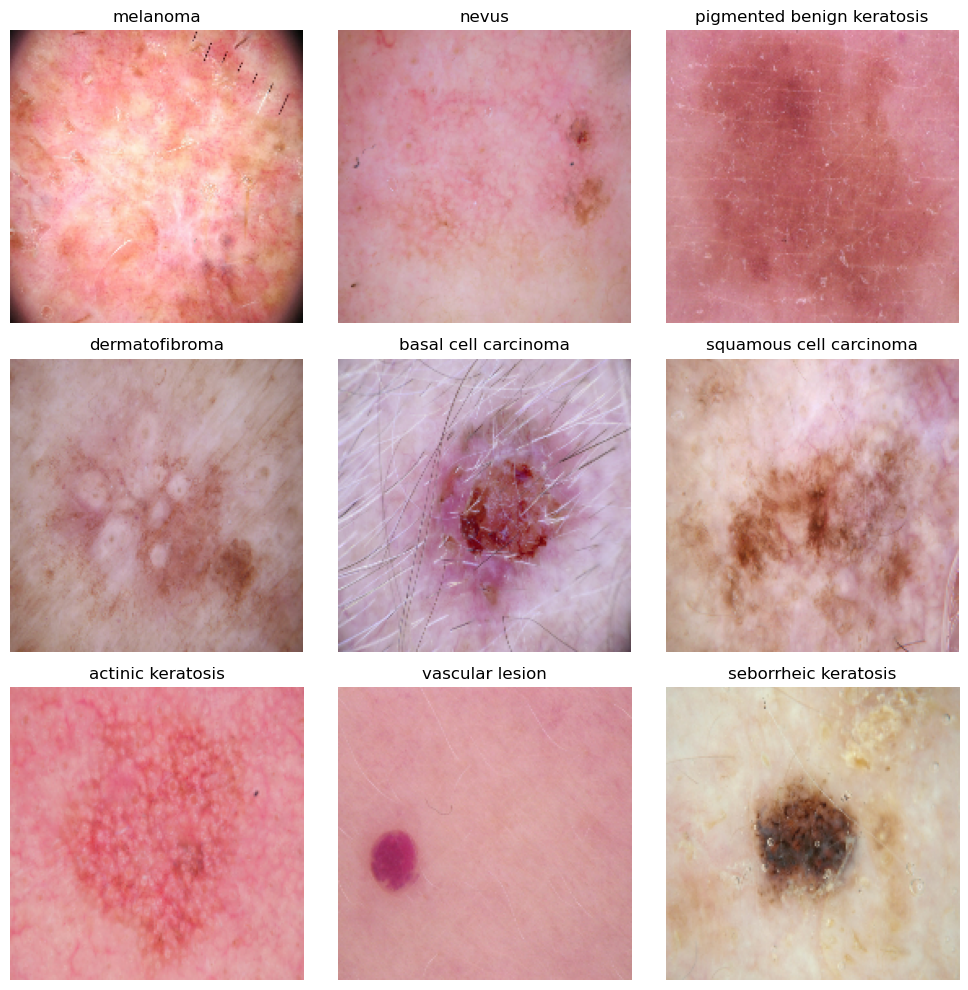

In [11]:
import matplotlib.pyplot as plt

# This dictionary will hold one image for each class
class_images = {}

# Iterate over the dataset to collect the first instance of each class
for images, labels in train_ds:
    for image, label in zip(images, labels):
        class_name = class_names[label]
        if class_name not in class_images:
            class_images[class_name] = image.numpy().astype('uint8')
        if len(class_images) == 9:  # Stop if we have collected one of each class
            break
    if len(class_images) == 9:
        break

# Plot the images
plt.figure(figsize=(10, 10))
for i, (class_name, image) in enumerate(class_images.items()):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis("off")

plt.tight_layout()
plt.show()


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model Building & Training (Initial)
A custom CNN model is created to detect the nine classes, with image rescaling as a part of the model.
An appropriate optimizer and loss function are chosen.
The model is trained for ~20 epochs, and the fit is assessed for evidence of overfitting or underfitting.`

In [13]:
%%time

import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model
model = models.Sequential([
    # Rescaling layer to normalize pixel values
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
    # Convolutional base
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Flattening the output of the conv base to feed into the dense layers
    layers.Flatten(),
    
    # Dense layers for classification
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')  # Use softmax for multi-class classification
])




CPU times: total: 625 ms
Wall time: 508 ms


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Train the model

In [16]:
%%time

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


112/112 [==============================] - 43s 322ms/step - loss: 2.0313 - accuracy: 0.2472 - val_loss: 2.2620 - val_accuracy: 0.2174
Epoch 2/20
112/112 [==============================] - 35s 314ms/step - loss: 1.7195 - accuracy: 0.3901 - val_loss: 2.4867 - val_accuracy: 0.2174
Epoch 3/20
112/112 [==============================] - 37s 332ms/step - loss: 1.5432 - accuracy: 0.4604 - val_loss: 2.2397 - val_accuracy: 0.2609
Epoch 4/20
112/112 [==============================] - 35s 314ms/step - loss: 1.4210 - accuracy: 0.4983 - val_loss: 2.3422 - val_accuracy: 0.3043
Epoch 5/20
112/112 [==============================] - 34s 305ms/step - loss: 1.3926 - accuracy: 0.5128 - val_loss: 3.1910 - val_accuracy: 0.1739
Epoch 6/20
112/112 [==============================] - 35s 314ms/step - loss: 1.3240 - accuracy: 0.5363 - val_loss: 2.3139 - val_accuracy: 0.2174
Epoch 7/20
112/112 [==============================] - 34s 306ms/step - loss: 1.2580 - accuracy: 0.5469 - val_loss: 3.6200 - val_

### Visualizing training results

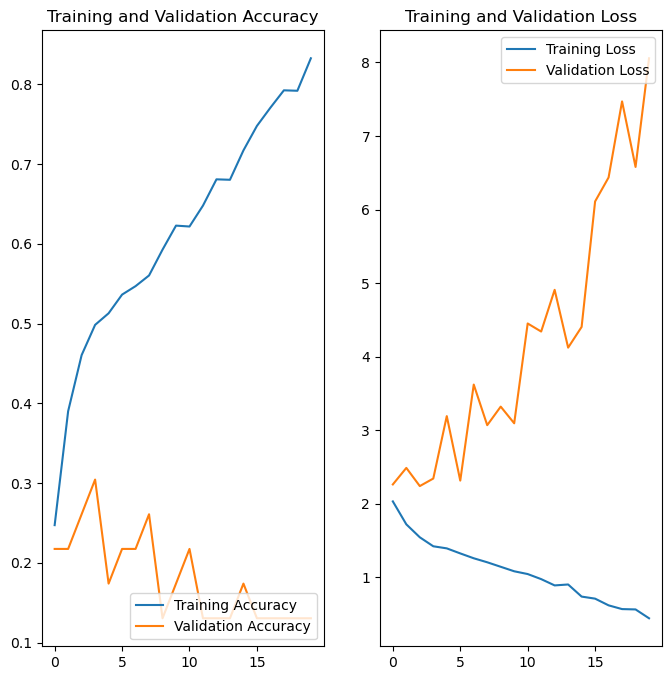

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<a id="basic_model"></a>#### Initial Model Asssesmet

#### As we observe this model is severly Overfitting as the Validation accuracy is too low. (val_accuracy: 0.1304).

Epoch 20/20
112/112 [==============================] - 34s 302ms/step - loss: 0.4420 - accuracy: 0.8326 - val_loss: 8.0570 - val_accuracy: 0.1304

## Data Augmentation

### A data augmentation strategy is implemented to address any fitting issues.


Found 2239 files belonging to 9 classes.


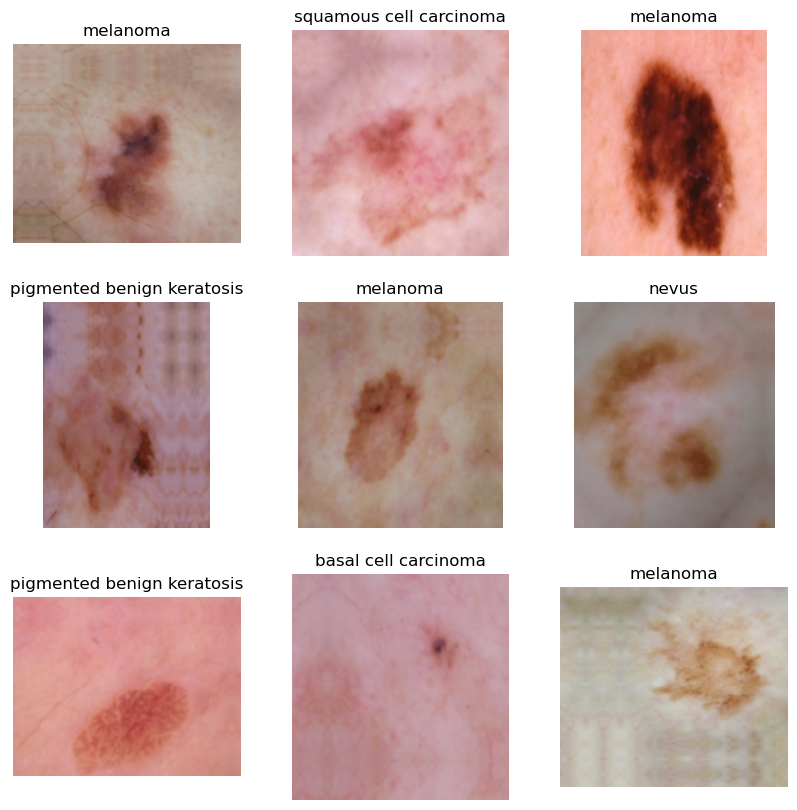

CPU times: total: 19.3 s
Wall time: 7.53 s


In [18]:
%%time 

import tensorflow as tf
import matplotlib.pyplot as plt

# Load the datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    image_size=(180, 180),
    batch_size=32
)

# Store class names before applying the map transformation
class_names = train_ds.class_names

# Define the data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2)
])

# Shuffle the dataset and take one batch
shuffled_train_ds = train_ds.shuffle(1000)  # Shuffle with a buffer size of 1000
shuffled_batch = shuffled_train_ds.take(1)

# Visualize the augmented images
plt.figure(figsize=(10, 10))
for images, labels in shuffled_batch:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # Apply augmentation to the i-th image in the shuffled batch
        augmented_image = data_augmentation(tf.expand_dims(images[i], 0), training=True)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.show()
    break  # We only need the first shuffled batch, so break after processing it


### Data Augmentation with Augmentor

Augmentor package is used to add more image samples, say 500 to each class. It also does some image transformation such as rotation.


In [19]:
!pip install Augmentor

In [20]:
%%time

import Augmentor

# Loop over the class names and create an Augmentor pipeline for each class
for i in class_names:
    # Create an Augmentor Pipeline for the current class directory
    p = Augmentor.Pipeline(str(data_dir_train / i))  # Use the '/' operator to join paths with pathlib
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  # We are adding 500 samples per class to make sure that none of the classes are sparse.


Initialised with 114 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1FB0A70F590>: 100%|█| 500/500 [00:06<00:00, 75.48 Samples/


Initialised with 376 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1FB094A1010>: 100%|█| 500/500 [00:06<00:


Initialised with 95 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1FB0A8D2290>: 100%|█| 500/500 [00:07<00:00, 70.94 Samples/


Initialised with 438 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x1FB3ECF6550>: 100%|█| 500/500 [00:31<00:00, 15.76 Samples/


Initialised with 357 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1FB0B9E0CD0>: 100%|█| 500/500 [00:29<00:00, 16.78 Samples/


Initialised with 462 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1FB0A7BA110>: 100%|█| 500/500 [00:06<00:00, 73.04 Samples/


Initialised with 77 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1FB0A893150>: 100%|█| 500/500 [00:16<00:00, 30.77 Samples


Initialised with 181 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1FB7ED85150>: 100%|█| 500/500 [00:06<00:00, 71.59 Samples/


Initialised with 139 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1FB0A77E110>: 100%|█| 500/500 [00:06<00:00, 72.30 Samples/

CPU times: total: 7min 14s
Wall time: 1min 59s


In [21]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [22]:
from pathlib import Path
import shutil

# data_dir_train is a Path object pointing to the training directory
output_dirs = list(data_dir_train.glob('*/output'))

for output_dir in output_dirs:
    for img_path in output_dir.glob('*.jpg'):
        # Define a new path for the image in the class directory
        new_path = img_path.parents[1] / img_path.name
        # Move the image
        shutil.move(str(img_path), str(new_path))
    # Optionally, remove the now-empty output directory
    output_dir.rmdir()


In [23]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    image_size=(180, 180),
    batch_size=batch_size
)

Found 6739 files belonging to 9 classes.


### Lets see the distribution of augmented data after adding new images to the original training data.

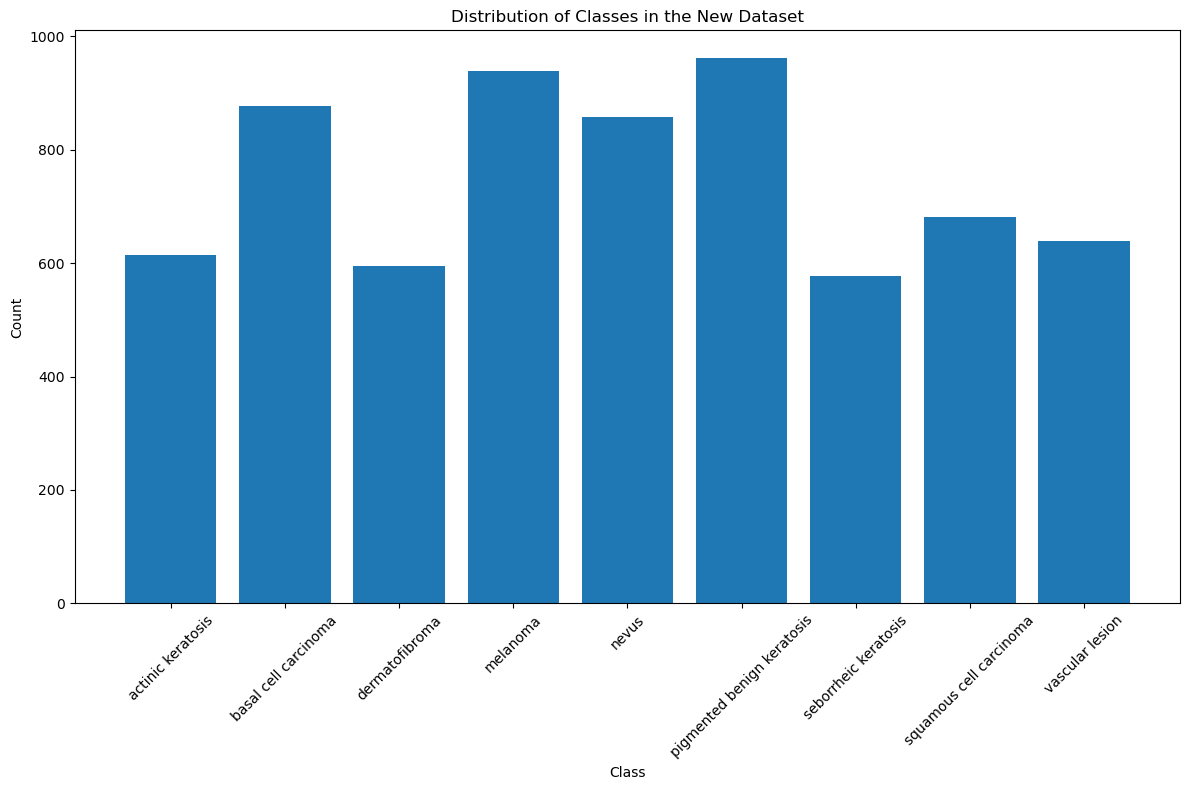

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# train_ds is the dataset that includes both original and augmented images

# Step 1: Extract class names
class_names = train_ds.class_names

# Step 2: Initialize a dictionary to hold the count of each class
class_counts = {class_name: 0 for class_name in class_names}

# Step 3: Iterate over the dataset to count each class
for images, label in train_ds.unbatch().as_numpy_iterator():
    class_name = class_names[label]
    class_counts[class_name] += 1

# Step 4: Plot the distribution
plt.figure(figsize=(12, 8))
plt.bar(class_counts.keys(), class_counts.values(), align='center')
plt.xticks(rotation=45)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Classes in the New Dataset')
plt.tight_layout() 
plt.show()


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## Model Building & Training (Post-Augmentation)

#### The model creation process is repeated with data augmentation in place. 
#### Now we include techniques such as BatchNormalization and Dropouts for preventing Overfitting.
#### The model is trained for ~20 initially and then additional epochs as needed.
#### EarlyStopping and ModelCheckpoint are also defined to optimize training resources.
#### The effectiveness of the augmentation strategy is evaluated.


#### ** Training Iteration1:

In [30]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers

# Setting a seed for reproducibility
tf.random.set_seed(42)

# Model constants
img_height, img_width = 180, 180  # Image dimensions
num_classes = 9  # Number of output classes

# Data augmentation layers
data_augmentation = tf.keras.Sequential([
  preprocessing.RandomFlip('horizontal_and_vertical'),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.1),
  preprocessing.RandomContrast(0.1),
])

# Building the model
model = models.Sequential([
    # Input layer that specifies the input shape of the images
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    
    # Data augmentation
    data_augmentation,
    
    # Rescaling layer to normalize pixel values
    preprocessing.Rescaling(1./255),
    
    # Convolutional blocks
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Flattening the output to feed into the dense layer
    layers.Flatten(),
    
    # Dense layers with dropout and L2 regularization
    layers.Dense(512, activation='relu', kernel_initializer='he_normal',
                 kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(256, activation='relu', kernel_initializer='he_normal',
                 kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    # Output layer with softmax activation for classification
    layers.Dense(num_classes, activation='softmax'),
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='model_best_checkpoint.h5', monitor='val_loss', save_best_only=True, verbose=1)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_4 (Bat  (None, 180, 180, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 90, 90, 64)       

In [31]:
%%time

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,  # Adjust epochs based on early stopping
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/20
422/422 [==============================] - ETA: 0s - loss: 16.5442 - accuracy: 0.3165
Epoch 1: val_loss improved from inf to 15.53604, saving model to model_best_checkpoint.h5
422/422 [==============================] - 244s 569ms/step - loss: 16.5442 - accuracy: 0.3165 - val_loss: 15.5360 - val_accuracy: 0.1739
Epoch 2/20
422/422 [==============================] - ETA: 0s - loss: 13.6157 - accuracy: 0.3864
Epoch 2: val_loss improved from 15.53604 to 12.44820, saving model to model_best_checkpoint.h5
422/422 [==============================] - 242s 573ms/step - loss: 13.6157 - accuracy: 0.3864 - val_loss: 12.4482 - val_accuracy: 0.3043
Epoch 3/20
422/422 [==============================] - ETA: 0s - loss: 11.1552 - accuracy: 0.4173
Epoch 3: val_loss improved from 12.44820 to 10.11520, saving model to model_best_checkpoint.h5
422/422 [==============================] - 235s 556ms/step - loss: 11.1552 - accuracy: 0.4173 - val_loss: 10.1152 - val_accuracy: 0.3478
Epoch 4/20
422/422

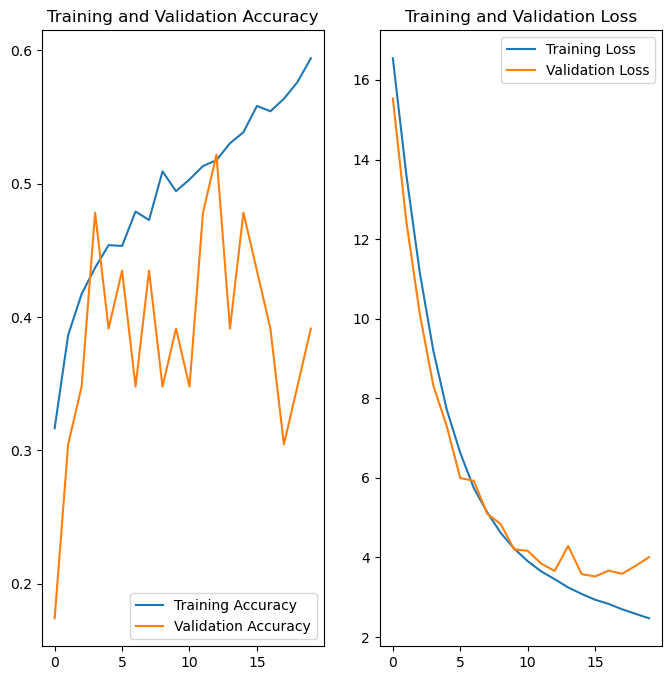

In [32]:
# Extracting the history of training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Adjust epochs_range based on the actual number of epochs trained
epochs_range = range(len(acc))

import matplotlib.pyplot as plt

# Plotting training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Iteration1 Observation:

#### We see that we brought down the validation loss in parallel with training loss to some extent. There is some improvement with Validation accuracy although not much improvement. 

##### accuracy: 0.5584 - val_accuracy: 0.4348

Epoch 16: val_loss improved from 3.58173 to 3.52130, saving model to model_best_checkpoint.h5
422/422 [==============================] - 243s 576ms/step - loss: 2.9371 - accuracy: 0.5584 - val_loss: 3.5213 - val_accuracy: 0.4348

#### ** Training Iteration 2:

Here we add another 10 epochs to see if that helps with accuracy improvement.

In [33]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Optimizing the data pipeline for efficiency
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Callbacks for further training
# EarlyStopping: Monitor validation loss, with patience for N epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# ModelCheckpoint: Save the best model based on validation loss
model_checkpoint = ModelCheckpoint(filepath='model_best_checkpoint_further.h5', monitor='val_loss', save_best_only=True, verbose=1)

# ReduceLROnPlateau: Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

# Retrieve the last epoch number from initial training
initial_epochs = len(history.history['loss'])
additional_epochs = 10
total_epochs = initial_epochs + additional_epochs

# Continue training for additional epochs
history_continued = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=initial_epochs,  # Start from the last completed epoch
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 21/30
422/422 [==============================] - ETA: 0s - loss: 2.4008 - accuracy: 0.6005
Epoch 21: val_loss improved from inf to 3.28570, saving model to model_best_checkpoint_further.h5
422/422 [==============================] - 242s 573ms/step - loss: 2.4008 - accuracy: 0.6005 - val_loss: 3.2857 - val_accuracy: 0.3478 - lr: 1.0000e-04
Epoch 22/30
422/422 [==============================] - ETA: 0s - loss: 2.2971 - accuracy: 0.6019
Epoch 22: val_loss did not improve from 3.28570
422/422 [==============================] - 227s 538ms/step - loss: 2.2971 - accuracy: 0.6019 - val_loss: 3.5228 - val_accuracy: 0.3043 - lr: 1.0000e-04
Epoch 23/30
422/422 [==============================] - ETA: 0s - loss: 2.2129 - accuracy: 0.6203
Epoch 23: val_loss did not improve from 3.28570
422/422 [==============================] - 224s 531ms/step - loss: 2.2129 - accuracy: 0.6203 - val_loss: 4.1382 - val_accuracy: 0.3043 - lr: 1.0000e-04
Epoch 24/30
422/422 [==============================] - ETA:

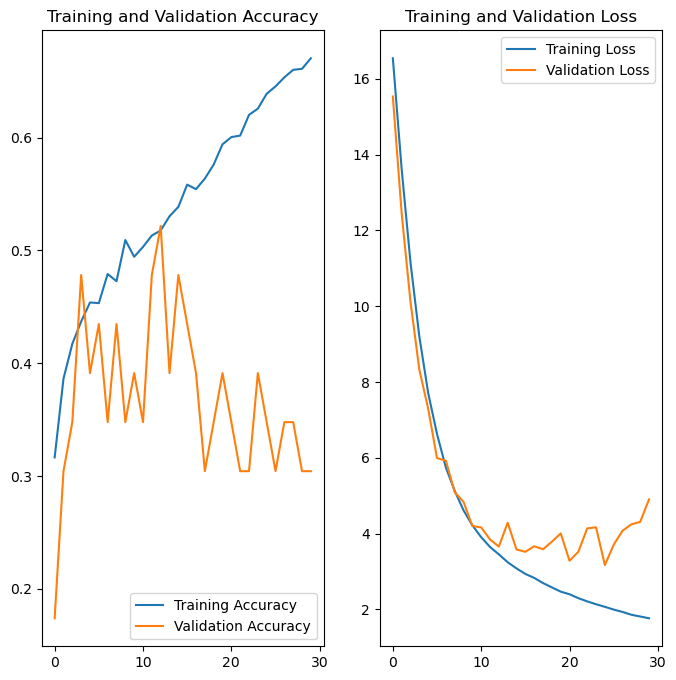

In [34]:
# Concatenate the history of the initial training and the continued training
acc = history.history['accuracy'] + history_continued.history['accuracy']
val_acc = history.history['val_accuracy'] + history_continued.history['val_accuracy']
loss = history.history['loss'] + history_continued.history['loss']
val_loss = history.history['val_loss'] + history_continued.history['val_loss']

# Adjust epochs_range based on the total number of epochs trained
epochs_range = range(len(acc))

import matplotlib.pyplot as plt

# Plotting training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#### Iteration2 Observation:

##### We see that the Accuracy has improved but Validation accuracy has more scope for improvement.

##### accuracy: 0.6390 - val_accuracy: 0.3478

Epoch 25/30
422/422 [==============================] - ETA: 0s - loss: 2.0694 - accuracy: 0.6390
Epoch 25: val_loss improved from 3.28570 to 3.17016, saving model to model_best_checkpoint_further.h5
422/422 [==============================] - 227s 538ms/step - loss: 2.0694 - accuracy: 0.6390 - val_loss: 3.1702 - val_accuracy: 0.3478 - lr: 1.0000e-04

### ** Training Iteration3:

##### We continue training to see if the best model can improve validation accuracy further. We add EarlyStopping and let it continue for another 50 epochs.

In [37]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='model_best_checkpoint_continued.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

# 'history_continued' is from the last training session and contains its history
initial_epochs = len(history_continued.history['loss'])
additional_epochs = 50
total_epochs = initial_epochs + additional_epochs

# Continue training for additional epochs
history_continued_further = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=initial_epochs,  # Ensure this is set correctly based on previous training
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 11/60
422/422 [==============================] - ETA: 0s - loss: 1.6220 - accuracy: 0.7057
Epoch 11: val_loss improved from inf to 4.44198, saving model to model_best_checkpoint_continued.h5
422/422 [==============================] - 234s 553ms/step - loss: 1.6220 - accuracy: 0.7057 - val_loss: 4.4420 - val_accuracy: 0.3478 - lr: 2.0000e-05
Epoch 12/60
422/422 [==============================] - ETA: 0s - loss: 1.5250 - accuracy: 0.7222
Epoch 12: val_loss improved from 4.44198 to 4.35251, saving model to model_best_checkpoint_continued.h5
422/422 [==============================] - 224s 531ms/step - loss: 1.5250 - accuracy: 0.7222 - val_loss: 4.3525 - val_accuracy: 0.3478 - lr: 2.0000e-05
Epoch 13/60
422/422 [==============================] - ETA: 0s - loss: 1.4444 - accuracy: 0.7379
Epoch 13: val_loss did not improve from 4.35251
422/422 [==============================] - 223s 529ms/step - loss: 1.4444 - accuracy: 0.7379 - val_loss: 4.4361 - val_accuracy: 0.3913 - lr: 2.0000e-05
E

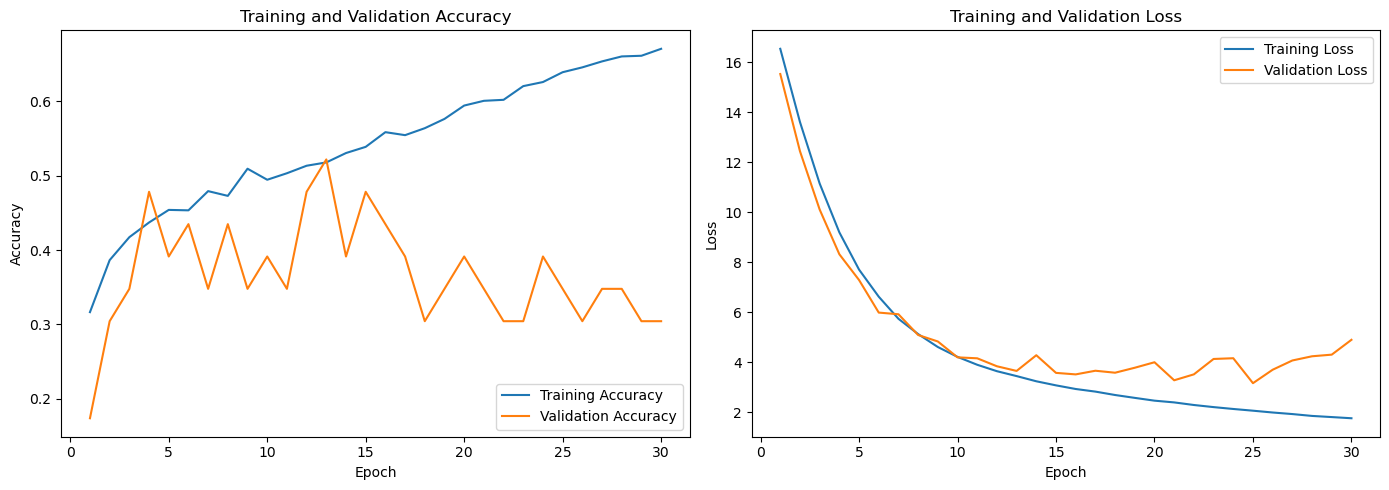

In [38]:
import matplotlib.pyplot as plt

# Concatenate the history from initial and continued training
acc = history.history['accuracy'] + history_continued.history['accuracy']
val_acc = history.history['val_accuracy'] + history_continued.history['val_accuracy']
loss = history.history['loss'] + history_continued.history['loss']
val_loss = history.history['val_loss'] + history_continued.history['val_loss']

# Determine the total range of epochs trained
epochs_range = range(1, len(acc) + 1)  # Starting from 1 for readability

# Setup the plotting
plt.figure(figsize=(14, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()  
plt.show()

### Iteration3 Observation:

#### Finally, we see that the Accuracy has improved but Validation accuracy has scope for improvement even with Dropouts/BatchNormalization/L2 regularization and LearningRate tuning.

#### Best Model for current Network design:  accuracy: 0.7648 - val_accuracy: 0.3478

Epoch 17/60
422/422 [==============================] - ETA: 0s - loss: 1.2483 - accuracy: 0.7648
Epoch 17: val_loss improved from 4.12019 to 3.80170, saving model to model_best_checkpoint_continued.h5
422/422 [==============================] - 234s 555ms/step - loss: 1.2483 - accuracy: 0.7648 - val_loss: 3.8017 - val_accuracy: 0.3478 - lr: 2.0000e-05*



Epoch 27: ReduceLROnPlateau reducing learning rate to 1e-06.
422/422 [==============================] - 222s 526ms/step - loss: 0.9929 - accuracy: 0.8204 - val_loss: 4.7156 - val_accuracy: 0.3043 - lr: 4.0000e-06
Epoch 27: early stopping

###### Note: We have improved the validation accuracy considerably when compared to the [Initial Model](#basic_model).
